## Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load data
import tensorflow
from tensorflow import keras
import numpy as np
from scipy.io import loadmat
data = loadmat('/content/drive/MyDrive/6March2021_Prediction/data_norm_160.mat')
data = data['data_norm']
import os
newpath = r'/content/drive/MyDrive/6March2021_Prediction/1step_prediction/' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
os.chdir(newpath)

In [ ]:
# split data randomly (100,40,20)
np.random.seed(0) 
idx = np.random.permutation(160)
print(idx)
idx_train = idx[0:100]
idx_val = idx[100:140]
idx_test = idx[140:]
print(idx_train,idx_val,idx_test)
data_train = data[idx_train,0]
data_val = data[idx_val,0]
data_test = data[idx_test,0]

[110 112 143   7  44 101 122  66  85  86 133  92  26 146 119  62  51  97
 128  90  45  56  59   8  37  33 147  61  98 121 135  24  54  80  19  74
 131  16  60 120  40  22  63 151 111 145 136  27 118  95  55 109  18 157
  30  94  73 107   2 139  83  43  71  10 141 154  96  89 144 132 124  50
 100 142  64 106 108  69  49  48  13 158  23 113  20  15  78  52  76   3
 159  93   6  68  75  84 129  12 123  14 125  91 137  46  11 102  35  57
  41 156  65   1 130 148  42 105   4 138  17 116 104  38   5  53 153 126
   0  34  28 114  31 134 127 149  32  29  99  82  79 115 155  72  77  25
  81 150 152  39  58 140  88  70  87  36  21   9 103  67 117  47]
[110 112 143   7  44 101 122  66  85  86 133  92  26 146 119  62  51  97
 128  90  45  56  59   8  37  33 147  61  98 121 135  24  54  80  19  74
 131  16  60 120  40  22  63 151 111 145 136  27 118  95  55 109  18 157
  30  94  73 107   2 139  83  43  71  10 141 154  96  89 144 132 124  50
 100 142  64 106 108  69  49  48  13 158  23 113  20  15  

In [ ]:
# multivariate multi-step encoder-decoder lstm example
from numpy import array
from numpy import hstack
from numpy import shape
from numpy import concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from keras import backend
def rmse(y_true, y_pred):
 return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix,0:-1] #label prediction removed
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
# define input sequence
X_train,y_train,X_val,y_val,X_test,y_test = list(),list(),list(),list(),list(),list()
# choose a number of time steps
n_steps_in, n_steps_out = 30, 1
for i in range(data_train.shape[0]):
    dataset = data_train[i][:,1:] # drop time series
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)
    X_train.append(X)
    y_train.append(y)
for i in range(data_val.shape[0]):
    dataset = data_val[i][:,1:] # drop time series
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)
    X_val.append(X)
    y_val.append(y)
for i in range(data_test.shape[0]):
    dataset = data_test[i][:,1:] # drop time series
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)
    X_test.append(X)
    y_test.append(y)

In [ ]:
# push all lists into one 3D array
X_train_all,y_train_all,X_val_all,y_val_all,X_test_all,y_test_all = X_train[0],y_train[0],X_val[0],y_val[0],X_test[0],y_test[0]
for i in range(1,shape(X_train)[0]):
    X_train_all = concatenate((X_train_all,X_train[i]))
    y_train_all = concatenate((y_train_all,y_train[i]))
for i in range(1,shape(X_val)[0]):
    X_val_all = concatenate((X_val_all,X_val[i]))
    y_val_all = concatenate((y_val_all,y_val[i]))
for i in range(1,shape(X_test)[0]):
    X_test_all = concatenate((X_test_all,X_test[i]))
    y_test_all = concatenate((y_test_all,y_test[i]))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
# y_train_all.reshape(y_train_all.shape[0],y_train_all.shape[1],1)
# y_val_all.reshape(y_val_all.shape[0],y_val_all.shape[1],1)

In [ ]:
# save X_train,y_train,X_val,y_val,X_test,y_test
from numpy import savez_compressed
savez_compressed('X_train_all.npz',X_train_all)
savez_compressed('y_train_all.npz',y_train_all)
savez_compressed('X_val_all.npz',X_val_all)
savez_compressed('y_val_all.npz',y_val_all)
savez_compressed('X_test_all.npz',X_test_all)
savez_compressed('y_test_all.npz',y_test_all)

In [ ]:
# from numpy import savez
# savez('E:/Study/Jupyter/Forecasting/Data/X_train_all2.npz','X_train_all')
# savez('E:/Study/Jupyter/Forecasting/Data/y_train_all2.npz','y_train_all')
# savez('E:/Study/Jupyter/Forecasting/Data/X_val_all2.npz','X_val_all')
# savez('E:/Study/Jupyter/Forecasting/Data/y_val_all2.npz','y_val_all')
# savez('E:/Study/Jupyter/Forecasting/Data/X_test_all2.npz','X_test_all')
# savez('E:/Study/Jupyter/Forecasting/Data/y_test_all2.npz','y_test_all')

In [ ]:
# # customize keras.model.fit
# class CustomModel(tensorflow.keras.Model):
#     def train_step(self, data):
#         # Unpack the data. Its structure depends on your model and
#         # on what you pass to `fit()`.
#         x, y = data

#         with tf.GradientTape() as tape:
#             y_pred = self(x, training=True)  # Forward pass
#             # Compute the loss value
#             # (the loss function is configured in `compile()`)
#             loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

#         # Compute gradients
#         trainable_vars = self.trainable_variables
#         gradients = tape.gradient(loss, trainable_vars)
#         # Update weights
#         self.optimizer.apply_gradients(zip(gradients, trainable_vars))
#         # Update metrics (includes the metric that tracks the loss)
#         self.compiled_metrics.update_state(y, y_pred)
#         # Return a dict mapping metric names to current value
#         return {m.name: m.result() for m in self.metrics}

In [ ]:
# the dataset knows the number of features, e.g. 2
n_features = 11
n_epochs = 100
# define model
model = Sequential()
model.add(LSTM(300, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(300, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(10)))
model.compile(optimizer='adam', loss=rmse, metrics=['mae'])
# fit and save model
model.fit(X_train_all, y_train_all, epochs=n_epochs,validation_data=(X_val_all, y_val_all),verbose=2)

Epoch 1/100
740/740 - 35s - loss: 0.0796 - mae: 0.0645 - val_loss: 0.0519 - val_mae: 0.0410
Epoch 2/100
740/740 - 33s - loss: 0.0331 - mae: 0.0257 - val_loss: 0.0335 - val_mae: 0.0259
Epoch 3/100
740/740 - 32s - loss: 0.0242 - mae: 0.0189 - val_loss: 0.0247 - val_mae: 0.0196
Epoch 4/100
740/740 - 32s - loss: 0.0192 - mae: 0.0151 - val_loss: 0.0173 - val_mae: 0.0136
Epoch 5/100
740/740 - 32s - loss: 0.0162 - mae: 0.0128 - val_loss: 0.0161 - val_mae: 0.0128
Epoch 6/100
740/740 - 32s - loss: 0.0143 - mae: 0.0113 - val_loss: 0.0140 - val_mae: 0.0111
Epoch 7/100
740/740 - 32s - loss: 0.0126 - mae: 0.0099 - val_loss: 0.0137 - val_mae: 0.0111
Epoch 8/100
740/740 - 32s - loss: 0.0112 - mae: 0.0090 - val_loss: 0.0100 - val_mae: 0.0078
Epoch 9/100
740/740 - 32s - loss: 0.0103 - mae: 0.0082 - val_loss: 0.0107 - val_mae: 0.0084
Epoch 10/100
740/740 - 32s - loss: 0.0094 - mae: 0.0075 - val_loss: 0.0110 - val_mae: 0.0086
Epoch 11/100
740/740 - 32s - loss: 0.0088 - mae: 0.0070 - val_loss: 0.0093 - va

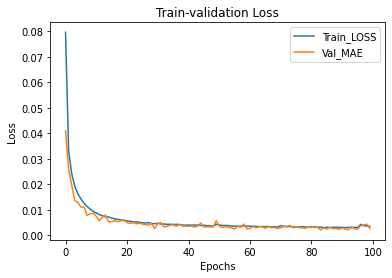

In [ ]:
train_loss = model.history.history['loss']
val_mae = model.history.history['val_mae']
savez_compressed('train_loss.npz',train_loss)
savez_compressed('val_mae.npz',val_mae)
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(range(n_epochs),train_loss,label="Train_LOSS")
plt.plot(range(n_epochs),val_mae,label="Val_MAE")
plt.legend()
plt.title("Train-validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
plt.savefig("train-val_loss.png")

<Figure size 432x288 with 0 Axes>

In [ ]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

In [ ]:
model.save('LSTM_All.h5')

In [ ]:
# demonstrate prediction--test
x_input = X_test_all
print(x_input.shape)
# reconstructed_model = keras.models.load_model('LSTM_All.h5')
yhat_test = model.predict(x_input, verbose=0)
savez_compressed('y_test_hat.npz',yhat_test)
print(yhat_test.shape)

# demonstrate prediction--val
x_input = X_val_all
print(x_input.shape)
# reconstructed_model = keras.models.load_model('LSTM_All.h5')
yhat_val = model.predict(x_input, verbose=0)
savez_compressed('y_val_hat.npz',yhat_val)
print(yhat_val.shape)

# demonstrate prediction--train
x_input = X_train_all
print(x_input.shape)
# reconstructed_model = keras.models.load_model('LSTM_All.h5')
yhat_train = model.predict(x_input, verbose=0)
savez_compressed('y_train_hat.npz',yhat_train)
print(yhat_train.shape)

(4780, 30, 11)
(4780, 1, 10)
(9325, 30, 11)
(9325, 1, 10)
(23655, 30, 11)
(23655, 1, 10)
